In [1]:
import easyocr
import onnxruntime
import os
import string
from matplotlib import pyplot as plt
import difflib
import sys
sys.path.append('/home/tandonsa/PycharmProjects/side_project/ocr_mawaqif/')
from src.utils import infer_utils

# add NLP Models
en_model = easyocr.Reader(['en'])
ar_model = easyocr.Reader(['ar'])
nlp_models = [en_model,ar_model]
Model_path= "/home/tandonsa/PycharmProjects/side_project/ocr_mawaqif/src/model/yolov4_1_3_320_320_static.onnx"
model = onnxruntime.InferenceSession(Model_path)

/home/tandonsa/anaconda3/envs/tf-2.5/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
/home/tandonsa/anaconda3/envs/tf-2.5/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [2]:
import logging
import numpy as np
import cv2
import re
import logging as log
import string
import difflib


class Inference_engine:
    def __init__(self, input_image, detector_model, nlp_model, detector_conf=0.1, nlp_conf=0.4, iou_thresh=0.5):
        self.input_img = input_image
        self.input_img_width = self.input_img.shape[1]
        self.input_img_height = self.input_img.shape[0]
        # Define Prediction Cofficents
        self.detector_conf = detector_conf
        self.iou_thresh = iou_thresh
        self.nlp_conf = nlp_conf
        # flag for detection
        self.success_detection = False
        self.txt_data = None
        # Load the model once in the memory
        self.session = detector_model
        self.en_reader = nlp_model[0]
        self.ar_reader = nlp_model[1]

    def get_licenceplate_info(self, run_detector=False):
        IN_IMAGE_H = self.session.get_inputs()[0].shape[2]
        IN_IMAGE_W = self.session.get_inputs()[0].shape[3]
        if run_detector:
            print("runnig detector")
            decoded_img = self.decode_img(self.input_img, shape=(IN_IMAGE_H, IN_IMAGE_W))
            if decoded_img is not None:
                detections = self.detect(decoded_img)
                boxes = self.post_processing(detections, conf_thresh=self.detector_conf, nms_thresh=self.iou_thresh)
                self.bounding_cords = self.decode_boxes(boxes)
                if self.bounding_cords is None:
                    self.txt_data = self.NLP_model(self.input_img.copy(), nlp_confidence=self.nlp_conf)
                elif not self.check_out_of_bounds():
                    cropped_alpr = self.input_img[self.bounding_cords[1]-10:self.bounding_cords[3]+20,
                                   self.bounding_cords[0]:self.bounding_cords[2]]
                    self.txt_data = self.NLP_model(cropped_alpr.copy(), nlp_confidence=self.nlp_conf)
        else:
            self.txt_data = self.NLP_model(self.input_img, nlp_confidence=self.nlp_conf)
        return self.txt_data

    def enhance_image(self, crop_image, alpha=1.5, beta=0):
        gray_image = cv2.cvtColor(crop_image, cv2.COLOR_RGB2GRAY)
        blur_img = cv2.GaussianBlur(gray_image, (5, 5), 0)
        adpt_img = cv2.adaptiveThreshold(blur_img, 200, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 7, 3)
        return adpt_img

    def check_out_of_bounds(self):
        out_of_bounds = False
        if (self.bounding_cords[0] > self.input_img_width) and (self.bounding_cords[2] > self.input_img_width) and (
                self.bounding_cords[1] > self.input_img_height) and (self.bounding_cords[3] > self.input_img_height):
            out_of_bounds = True
        return out_of_bounds

        
    def NLP_model(self, cropped_img, nlp_confidence=0.0):
        en_meta_data = []
        # run NLP model on cropped image
        results_en = self.en_reader.readtext(cropped_img, allowlist=string.digits + string.ascii_uppercase)
        for rlt in results_en:
            en_meta_data.append([rlt[-1], rlt[-2]])
        results_ar = self.ar_reader.readtext(cropped_img)
        nlp_data, raw_data = infer_utils.evaluate_data(en_meta_data, results_ar)
        nlp_data.sort(key=len)
        return [nlp_data, raw_data]

    def detect(self, decoded_image):
        input_name = self.session.get_inputs()[0].name
        outputs = self.session.get_outputs()
        output_names = list(map(lambda output: output.name, outputs))
        detections = self.session.run(output_names, {input_name: decoded_image})
        return detections

    def nms_cpu(self, boxes, confs, nms_thresh=0.4, min_mode=False):
        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]
        areas = (x2 - x1) * (y2 - y1)
        order = confs.argsort()[::-1]
        keep = []
        while order.size > 0:
            idx_self = order[0]
            idx_other = order[1:]
            keep.append(idx_self)
            xx1 = np.maximum(x1[idx_self], x1[idx_other])
            yy1 = np.maximum(y1[idx_self], y1[idx_other])
            xx2 = np.minimum(x2[idx_self], x2[idx_other])
            yy2 = np.minimum(y2[idx_self], y2[idx_other])
            w = np.maximum(0.0, xx2 - xx1)
            h = np.maximum(0.0, yy2 - yy1)
            inter = w * h
            if min_mode:
                over = inter / np.minimum(areas[order[0]], areas[order[1:]])
            else:
                over = inter / (areas[order[0]] + areas[order[1:]] - inter)
            inds = np.where(over <= nms_thresh)[0]
            order = order[inds + 1]
        return np.array(keep)

    def post_processing(self, output, conf_thresh=0.3, nms_thresh=0.5):
        # [batch, num, 1, 4]
        box_array = output[0]
        # [batch, num, num_classes]
        confs = output[1]

        if type(box_array).__name__ != 'ndarray':
            box_array = box_array.cpu().detach().numpy()
            confs = confs.cpu().detach().numpy()
        num_classes = confs.shape[2]
        # [batch, num, 4]
        box_array = box_array[:, :, 0]
        # [batch, num, num_classes] --> [batch, num]
        max_conf = np.max(confs, axis=2)
        max_id = np.argmax(confs, axis=2)
        bboxes_batch = []
        for i in range(box_array.shape[0]):
            argwhere = max_conf[i] > conf_thresh
            l_box_array = box_array[i, argwhere, :]
            l_max_conf = max_conf[i, argwhere]
            l_max_id = max_id[i, argwhere]
            bboxes = []
            # nms for each class
            for j in range(num_classes):
                cls_argwhere = l_max_id == j
                ll_box_array = l_box_array[cls_argwhere, :]
                ll_max_conf = l_max_conf[cls_argwhere]
                ll_max_id = l_max_id[cls_argwhere]
                keep = self.nms_cpu(ll_box_array, ll_max_conf, nms_thresh)
                if (keep.size > 0):
                    ll_box_array = ll_box_array[keep, :]
                    ll_max_conf = ll_max_conf[keep]
                    ll_max_id = ll_max_id[keep]
                    for k in range(ll_box_array.shape[0]):
                        bboxes.append([ll_box_array[k, 0], ll_box_array[k, 1], ll_box_array[k, 2], ll_box_array[k, 3],
                                       ll_max_conf[k], ll_max_conf[k], ll_max_id[k]])
            bboxes_batch.append(bboxes)
        return bboxes_batch

    def decode_boxes(self, boxes):
        cords = None
        for i in range(len(boxes[0])):
            box = boxes[0]
            x1 = int(box[i][0] * self.input_img_width)
            y1 = int(box[i][1] * self.input_img_height)
            x2 = int(box[i][2] * self.input_img_width)
            y2 = int(box[i][3] * self.input_img_height)
            cords = (x1, y1, x2, y2)
        return cords

    @staticmethod
    def decode_img(img, shape=(320, 320), channel=3):
        output_img = None
        try:
            resized = cv2.resize(img, shape, interpolation=cv2.INTER_LINEAR)
            trp_img = np.transpose(resized, (2, 0, 1)).astype(np.float32)
            output_img = np.expand_dims(trp_img, axis=0)
            output_img /= 255.0
        except IOError as e:
            log.error('{}! Unable to read image'.format(e))
        return output_img

/home/tandonsa/anaconda3/envs/tf-2.5/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Text en: ['B', 'GJI', 'UAEAJMAR', 'L', 'E']
Digit en  []
Text ar : ['الامارات', 'وعجمان']
Digit ar: ['8', '15976']
city AJMAN
OCR model data: ['B', 'L', 'E', '8', '15976', 'AJMAN', 'وعجمان', 'الامارات']
raw: ['B', 'GJI', 'UAEAJMAR', 'L', 'E', 'الامارات', 'وعجمان', '8', '15976']


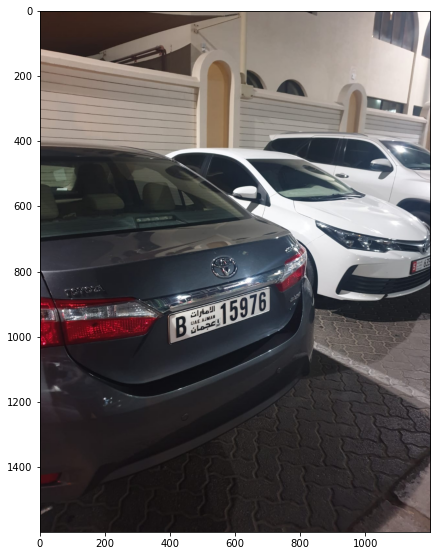

In [3]:
test_img_path = '/home/tandonsa/PycharmProjects/side_project/ocr_mawaqif/notebooks/test_imgs'
img_path = os.path.join(test_img_path,'10.jpeg')
import base64
encodedImage = base64.b64encode(open(img_path, "rb").read()).decode()
jpg_original = base64.b64decode(encodedImage)
jpg_as_np = np.frombuffer(jpg_original, dtype=np.uint8)
input_img = cv2.imdecode(jpg_as_np, flags=1)
input_img = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)


detector = False

model_infer = Inference_engine(input_img, model, nlp_models,detector_conf=0.5,nlp_conf=0.4, iou_thresh=0.5)

if detector:
    decoded_img = model_infer.decode_img(input_img)
    detections = model_infer.detect(decoded_img)
    boxes = model_infer.post_processing(detections, conf_thresh=0.5,nms_thresh=0.5)

    cords = model_infer.decode_boxes(boxes)
    f_image = cv2.rectangle(input_img,(cords[0],cords[1]),(cords[2],cords[3]),(0,255,0),3)
    crop_img = input_img[cords[1]-20:cords[3]+20,cords[0]-10:cords[2]+10]

    plt.figure(figsize=(7,17))
    plt.imshow(f_image)

    plt.figure()
    plt.imshow(crop_img)
else:
    plt.figure(figsize=(7,17))
    plt.imshow(input_img)

txt_data =model_infer.get_licenceplate_info(run_detector=detector)
print("OCR model data:",txt_data[0])
print("raw:",txt_data[1])

In [9]:
import itertools

list2d = [['dsdsd'], ['textss'], [''], ['uae']]
merged = list(itertools.chain(*list2d))
list(filter(str.strip, merged))

['dsdsd', 'textss', 'uae']